In [44]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from imblearn.over_sampling import RandomOverSampler
from scipy.cluster.vq import kmeans,vq
from scipy.cluster.hierarchy import fcluster,linkage
from scipy.stats.mstats import winsorize
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
# Setting some basic parameters for the analysis

%matplotlib inline

In [45]:
!wget https://raw.githubusercontent.com/dubey-0nkar/Cl653/main/well_log.csv
dataset_path = '/content/well_log.csv'

# Reading the well log dataset into memroy
df = pd.read_csv(dataset_path)
df = df.drop('Unnamed: 0', axis = 1)
# viewing the head of the dataset
df.head()



--2024-04-25 17:22:42--  https://raw.githubusercontent.com/dubey-0nkar/Cl653/main/well_log.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28177 (28K) [text/plain]
Saving to: ‘well_log.csv.4’

well_log.csv.4      100%[===================>]  27.52K  --.-KB/s    in 0.002s  

2024-04-25 17:22:42 (13.0 MB/s) - ‘well_log.csv.4’ saved [28177/28177]



,Depth,Gamma-ray,Shale_Volume,Restivity,Delta T,Vp,Vs,Density,Density_Calculated,Neuron_Porosity,Density_Porosity,Possions_Ratio,Classification
0,4000,73.215,0.7965,0.25,137.81,7256.3675,2799.0030,2.1278,2.1278,-999.25,0.2818,0.4126,0
1,4001,69.152,0.7391,0.20,138.06,7243.2276,2804.5841,2.1202,2.1202,-999.25,0.2893,0.4118,0
2,4002,65.965,0.6940,0.21,138.06,7243.2276,2817.0360,2.1149,2.1149,-999.25,0.2946,0.4109,0
3,4003,68.215,0.7258,0.27,137.31,7282.7908,2839.0723,2.1217,2.1217,-999.25,0.2889,0.4104,0
4,4004,70.840,0.7630,0.36,136.31,7336.2189,2870.3577,2.1301,2.1301,-999.25,0.2819,0.4096,0


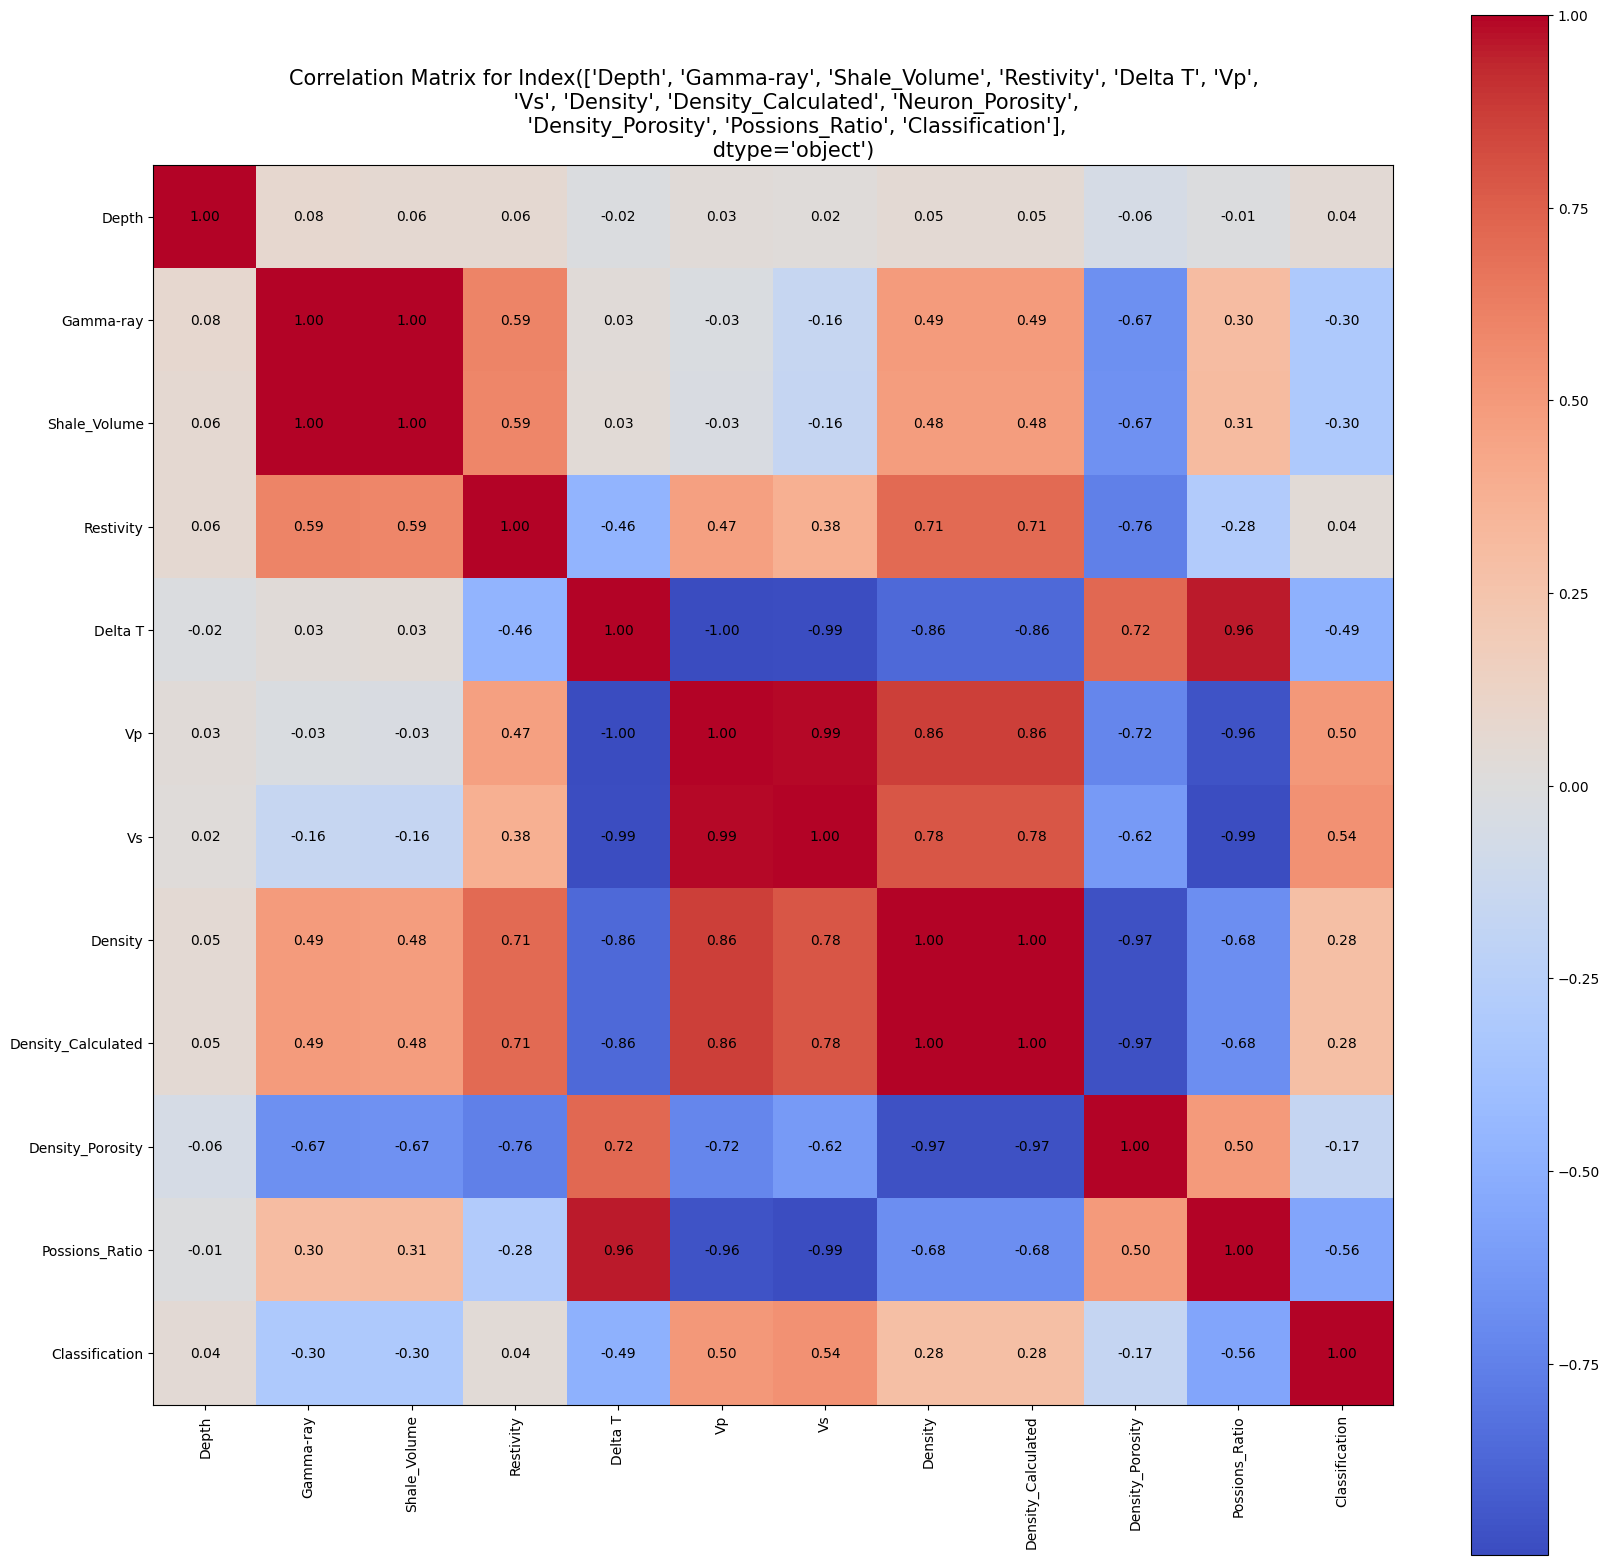

In [46]:
def plotCorrelationMatrix(df, graphWidth):
    filename = df.columns
    df = df.dropna() # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()

    fig, ax = plt.subplots(figsize=(graphWidth, graphWidth))
    corrMat = ax.matshow(corr, cmap='coolwarm')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)

    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            text = ax.text(j, i, "{:.2f}".format(corr.iloc[i, j]), ha="center", va="center", color="black")

    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


plotCorrelationMatrix(df,20)

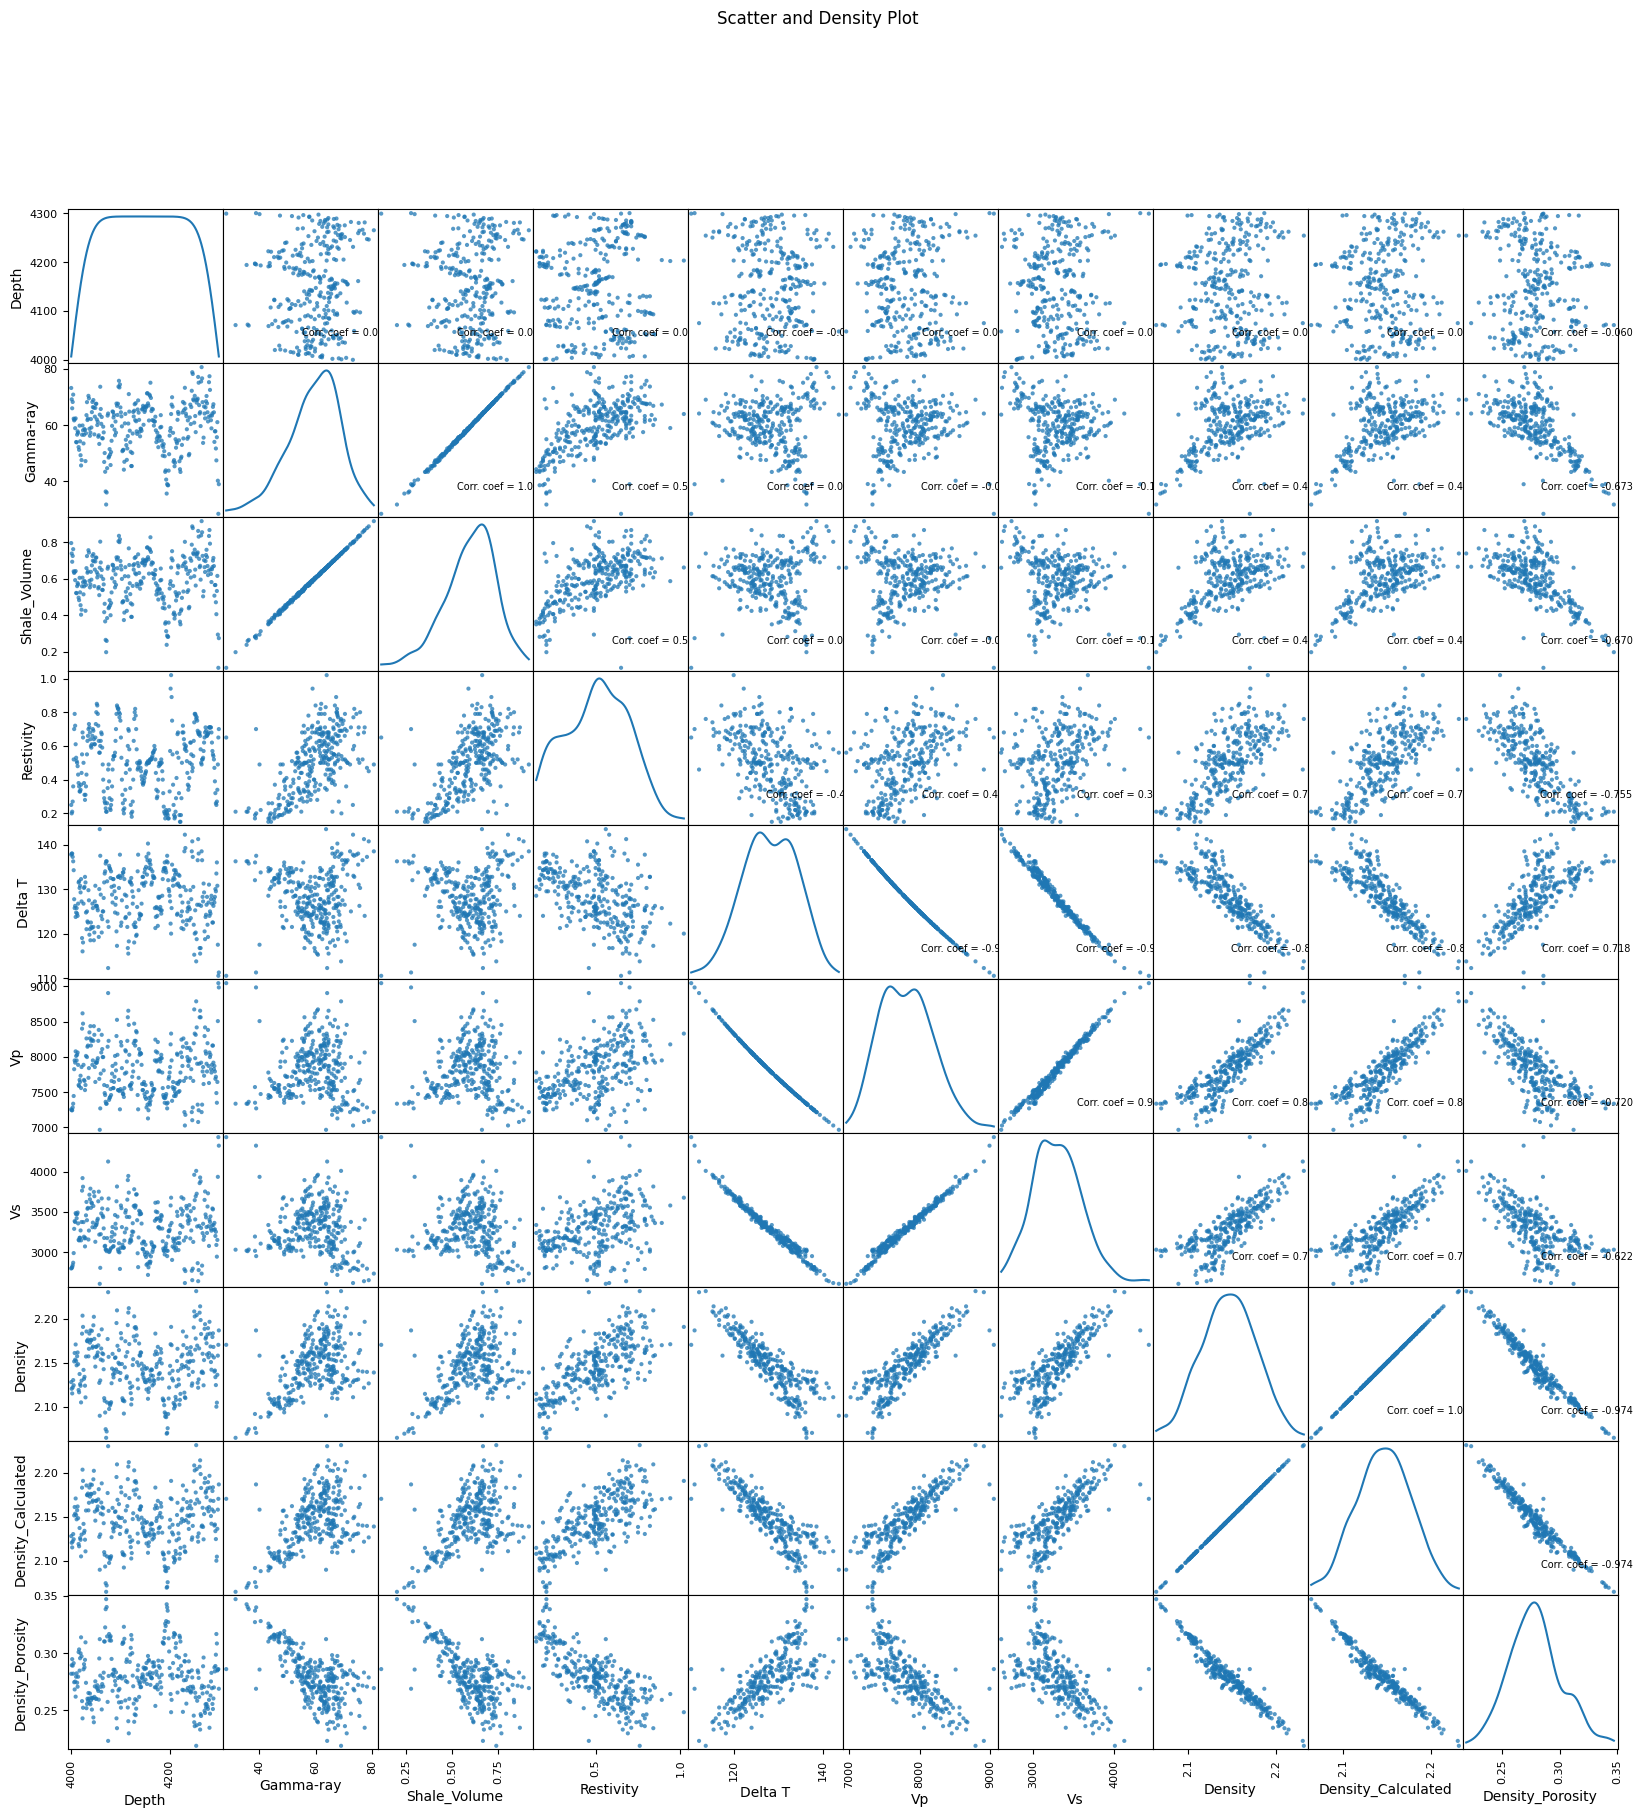

In [47]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna()
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

plotScatterMatrix(df, 20, 7)

DATA PREPROCESSING


In [48]:
df.isnull().sum()

Depth                 0
Gamma-ray             0
Shale_Volume          0
Restivity             0
Delta T               0
Vp                    0
Vs                    0
Density               0
Density_Calculated    0
Neuron_Porosity       0
Density_Porosity      0
Possions_Ratio        0
Classification        0
dtype: int64

In [49]:
def remove_outliers_zscore(data, threshold=3):

    z_scores = np.abs((data - data.mean()) / data.std())
    mask = (z_scores < threshold).all(axis=1)
    return data[mask]


cleaned_data = remove_outliers_zscore(df, threshold=3)

In [50]:
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler
scaler = MinMaxScaler()

# Fit and transform the data
df_normalized = scaler.fit_transform(df)

# Convert the numpy array back into a dataframe
df_normalized = pd.DataFrame(df_normalized, columns=df.columns)

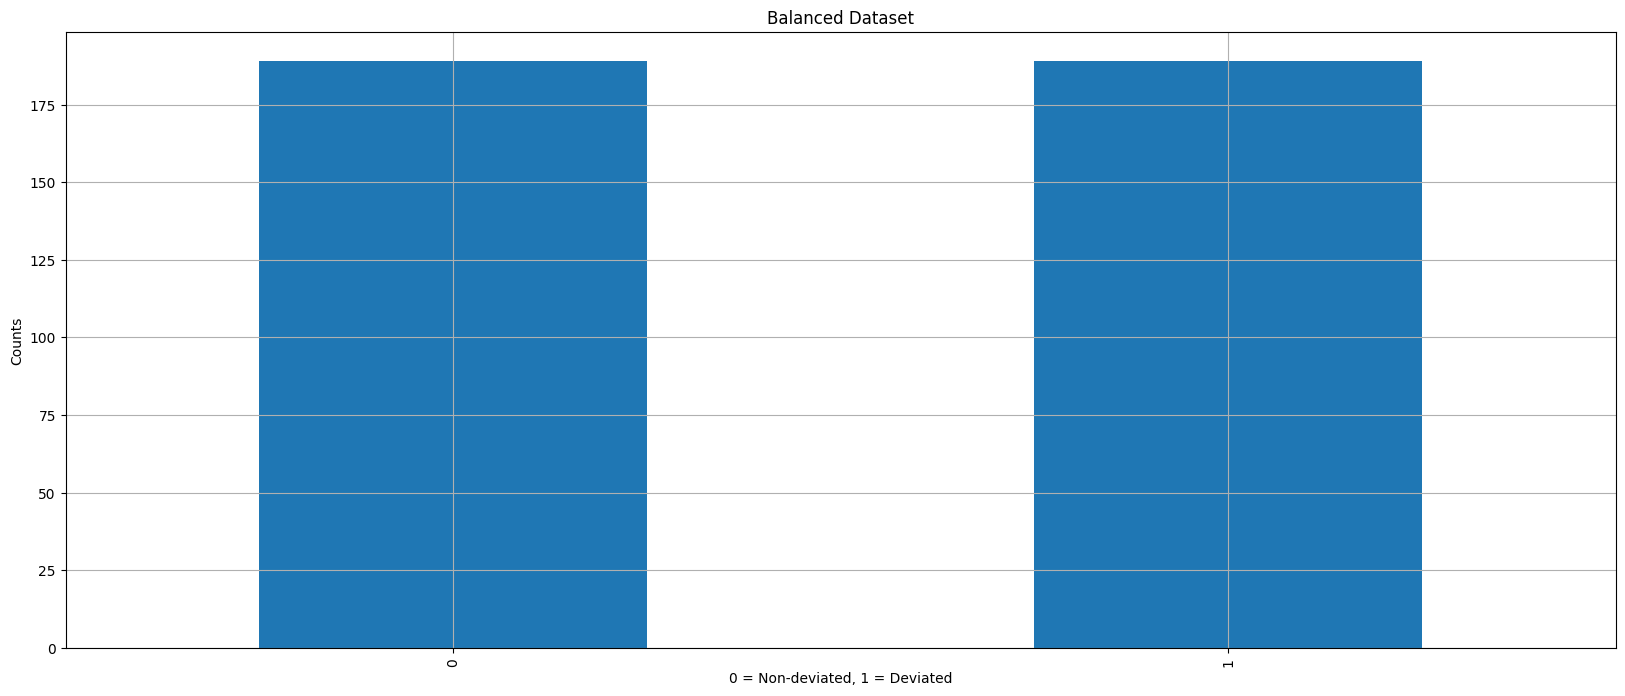

Deviated Class: 189
Non-Deviated Class: 189


In [51]:
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification



# Initialize a SMOTE instance
smote = SMOTE()

# Fit and resample the data
X, y = smote.fit_resample(df.drop('Classification', axis=1), df['Classification'])

# Combine the resampled features and target into a new DataFrame
df1_resampled = pd.concat([X, y], axis=1)

# showing a plot of the Balanced dataset
plt.figure(figsize = (20, 8))
pd.Series(y).value_counts().plot.bar()
plt.grid(True)
plt.title('Balanced Dataset')
plt.xlabel('0 = Non-deviated, 1 = Deviated')
plt.ylabel('Counts')
plt.show()

# Prining the counts of the Balanced Data
print('Deviated Class: {}'.format(pd.Series(y).value_counts()[0]))
print('Non-Deviated Class: {}'.format(pd.Series(y).value_counts()[1]))

Applying different models


In [52]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the classifier on the training set
rf_classifier.fit(X_train, y_train)

# Make predictions on the testing set
predictions = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.9736842105263158


In [53]:
lr=LogisticRegression(solver='liblinear')
svm=SVC(probability=True)
dt=DecisionTreeClassifier(max_depth=10,max_features=8,random_state=100)
rf=RandomForestClassifier(max_depth=4, max_features=3)

In [54]:
def apply_model(model,x_train,x_test,y_train,y_test):
    print(' '*20+re.search(r'(.*)\(',f'''{model}''',re.M).group(1))
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    print('')
    print('Train Score:  ',model.score(x_train,y_train))
    print('Test Score:   ',model.score(x_test,y_test))
    print('')
    print(classification_report(y_test,y_pred))

In [55]:
apply_model(lr,X_train,X_test,y_train,y_test)

                    LogisticRegression

Train Score:   0.8642384105960265
Test Score:    0.8421052631578947

              precision    recall  f1-score   support

           0       0.77      0.91      0.83        33
           1       0.92      0.79      0.85        43

    accuracy                           0.84        76
   macro avg       0.84      0.85      0.84        76
weighted avg       0.85      0.84      0.84        76



In [56]:
apply_model(svm,X_train,X_test,y_train,y_test)

                    SVC

Train Score:   0.7947019867549668
Test Score:    0.7105263157894737

              precision    recall  f1-score   support

           0       0.61      0.91      0.73        33
           1       0.89      0.56      0.69        43

    accuracy                           0.71        76
   macro avg       0.75      0.73      0.71        76
weighted avg       0.77      0.71      0.71        76



In [57]:
apply_model(rf,X_train,X_test,y_train,y_test)

                    RandomForestClassifier

Train Score:   0.9900662251655629
Test Score:    0.9342105263157895

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        33
           1       1.00      0.88      0.94        43

    accuracy                           0.93        76
   macro avg       0.93      0.94      0.93        76
weighted avg       0.94      0.93      0.93        76



In [58]:
apply_model(dt,X_train,X_test,y_train,y_test)

                    DecisionTreeClassifier

Train Score:   1.0
Test Score:    0.9605263157894737

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        33
           1       1.00      0.93      0.96        43

    accuracy                           0.96        76
   macro avg       0.96      0.97      0.96        76
weighted avg       0.96      0.96      0.96        76



#Hyperparameter tuning



In [59]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [60]:
# Define features and target
X = df.drop('Classification', axis=1)
y = df['Classification']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the models and parameters for grid search
models_params = {
    LogisticRegression(solver='liblinear',max_iter=1000): {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2']
    },
    KNeighborsClassifier(): {
        'n_neighbors': range(1, 10),
        'weights': ['uniform', 'distance']
    },
    DecisionTreeClassifier(): {
        'max_depth': range(1, 10),
        'criterion': ['gini', 'entropy']
    },
    RandomForestClassifier(): {
        'n_estimators': [10, 50, 100, 200],
        'max_depth': range(1, 10),
        'criterion': ['gini', 'entropy']
    }
}

# Perform hyperparameter tuning
for model, params in models_params.items():
    grid_search = GridSearchCV(model, params, cv=5, error_score='raise')
    try:
        grid_search.fit(X_train, y_train)
        print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
        print(f"Best score for {model.__class__.__name__}: {grid_search.best_score_}")
    except Exception as e:
        print(f"Error occurred during grid search for {model.__class__.__name__}: {e}")

Best parameters for LogisticRegression: {'C': 100, 'penalty': 'l1'}
Best score for LogisticRegression: 0.9541666666666668
Best parameters for KNeighborsClassifier: {'n_neighbors': 7, 'weights': 'distance'}
Best score for KNeighborsClassifier: 0.9458333333333332
Best parameters for DecisionTreeClassifier: {'criterion': 'gini', 'max_depth': 8}
Best score for DecisionTreeClassifier: 0.9833333333333334
Best parameters for RandomForestClassifier: {'criterion': 'entropy', 'max_depth': 4, 'n_estimators': 100}
Best score for RandomForestClassifier: 0.9791666666666667


##Comparing different model scores


In [61]:
models = {"Logistic Regression": LogisticRegression(max_iter=1000),
         "KNN": KNeighborsClassifier(),
         "Random Forest": RandomForestClassifier(),
         "Decision Tree": DecisionTreeClassifier()}

# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    np.random.seed(43)
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = cross_val_score(model,
                                             X_test,
                                             y_test,
                                            scoring='accuracy',
                                            cv=5
                                            ).mean()

    return model_scores

In [62]:
from sklearn.model_selection import cross_val_score
model_scores = fit_and_score(models,X_train,X_test,y_train,y_test)

model_scores

{'Logistic Regression': 0.8205128205128205,
 'KNN': 0.8192307692307693,
 'Random Forest': 0.9205128205128205,
 'Decision Tree': 0.885897435897436}

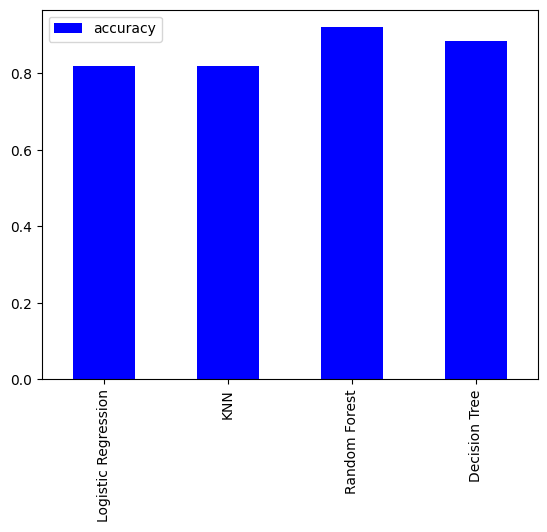

In [63]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar(color="blue");

In [64]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

<Axes: >

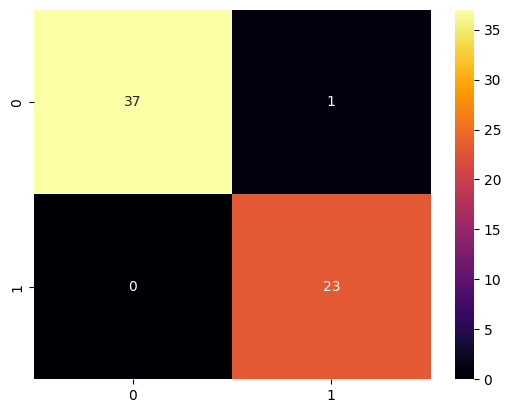

In [65]:
# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="inferno")

As we can see that the True Positive and True Negative percentages are higher than that of False Positive and False Negative, we can safely that our model makes fair predictions.

In [66]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.96      1.00      0.98        23

    accuracy                           0.98        61
   macro avg       0.98      0.99      0.98        61
weighted avg       0.98      0.98      0.98        61



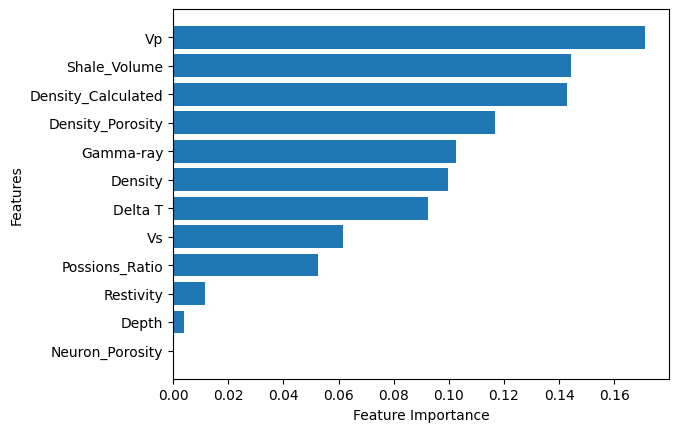

In [67]:
# Helper function for plotting feature importance
def plot_features(columns, importances,n=20):
    df = (pd.DataFrame({"features": columns,
                       "feature_importances": importances})
         .sort_values("feature_importances", ascending=False)
         .reset_index(drop=True))
    # Plot dataframe
    fix, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature Importance")
    ax.invert_yaxis()

plot_features(df.drop(['Classification'],axis=1).columns, model.feature_importances_)